<a href="https://colab.research.google.com/github/AshvinVignesh/DL_CW_2/blob/main/Roberta_TF_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from tensorflow.keras.layers import Dense
from transformers import TFRobertaForSequenceClassification,RobertaTokenizer
import pickle
from transformers import  AutoConfig,RobertaConfig

In [ ]:
import pandas as pd
df = pd.read_csv('yelp_reviews_2500.csv')
df=df.loc[:, ['stars', 'text']]
df

,stars,text
0,3.0,Cool structure to go see if visiting Nashville...
1,3.0,We planned a trip to Philly around my husbands...
2,3.0,Always good service. Room was clean except the...
3,3.0,"This place has been here for years and years, ..."
4,3.0,This is a very large location (with a ton of T...
...,...,...
2495,2.0,10/2/16 Update. I have been back twice since ...
2496,2.0,We were excited about Certa Pro completing our...
2497,2.0,Driven by numerous times and finally came in. ...
2498,2.0,Let me say that the service was excellent. The...


In [ ]:
def map_sentiment_scores(star_number):
    star_number = int(star_number)
    if star_number == 1:
        return 0
    elif star_number == 2:
        return 1
    elif star_number == 3:
        return 2
    elif star_number == 4:
        return 3
    elif star_number == 5:
        return 4

In [ ]:
df['stars'] = df.stars.apply(map_sentiment_scores)
df.head(5)

,stars,text
0,2,Cool structure to go see if visiting Nashville...
1,2,We planned a trip to Philly around my husbands...
2,2,Always good service. Room was clean except the...
3,2,"This place has been here for years and years, ..."
4,2,This is a very large location (with a ton of T...


In [ ]:
Text = df['text'].to_list()
labels = df['stars'].to_list()

In [ ]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 500

review = Text[0]

tokernizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

inputs = tokernizer(review, max_length=MAX_LEN, truncation=True, padding=True)

print(f'review: \'{review}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

review: 'Cool structure to go see if visiting Nashville.  If it is a pretty day with nice weather, take a picnic and enjoy Centennial Park while there!'
input ids: [0, 37739, 3184, 7, 213, 192, 114, 3918, 7024, 4, 1437, 318, 24, 16, 10, 1256, 183, 19, 2579, 1650, 6, 185, 10, 22297, 8, 2254, 7838, 13952, 861, 150, 89, 328, 2]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tokernizer(x, max_length=max_len, truncation=trucation, padding=padding)

encodings = construct_encodings(Text, tokernizer, max_len=MAX_LEN)

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

tfdataset = construct_tfdataset(encodings, labels)

In [ ]:
TEST_SPLIT = 0.2
BATCH_SIZE = 8

train_size = int(len(Text) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(Text))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
dropout_rate = 0.2


In [ ]:
config =RobertaConfig.from_pretrained(MODEL_NAME)

In [ ]:
config.attention_probs_dropout_prob = dropout_rate  # Set attention dropout rate
config.hidden_dropout_prob = dropout_rate  # Set hidden layer dropout rate
config.num_labels = 5

In [ ]:
N_EPOCHS = 5

roberta_model = TFRobertaForSequenceClassification.from_pretrained(MODEL_NAME, config = config)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
input_ids_layer = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="input_ids")
attention_mask_layer = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="attention_mask")

In [ ]:
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
dense_layer = tf.keras.layers.Dense(128, activation='relu')(roberta_output)
output = tf.keras.layers.Dense(5, activation='softmax')(dense_layer)

In [ ]:
model = tf.keras.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)

In [ ]:
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 500)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246494   ['input_ids[0][0]',           
 assification (TFRobertaFor  (loss=None, logits=(None,    77         'attention_mask[0][0]']      
 SequenceClassification)     5),                                                            

In [ ]:
history =model.fit(tfdataset_train,
                   batch_size=BATCH_SIZE,
                   epochs=N_EPOCHS)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 [==============================] - 297s 1s/step - loss: 1.4402 - accuracy: 0.3265
Epoch 2/5
250/250 [==============================] - 243s 971ms/step - loss: 1.2222 - accuracy: 0.4435
Epoch 3/5
250/250 [==============================] - 241s 965ms/step - loss: 1.0580 - accuracy: 0.5130
Epoch 4/5
250/250 [==============================] - 240s 960ms/step - loss: 0.9641 - accuracy: 0.5765
Epoch 5/5
250/250 [==============================] - 240s 958ms/step - loss: 0.9024 - accuracy: 0.6085


In [ ]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch

In [ ]:
history_df

,loss,accuracy,epoch
0,1.440230,0.3265,0
1,1.222156,0.4435,1
2,1.057970,0.5130,2
3,0.964116,0.5765,3
4,0.902422,0.6085,4


<Axes: xlabel='epoch'>

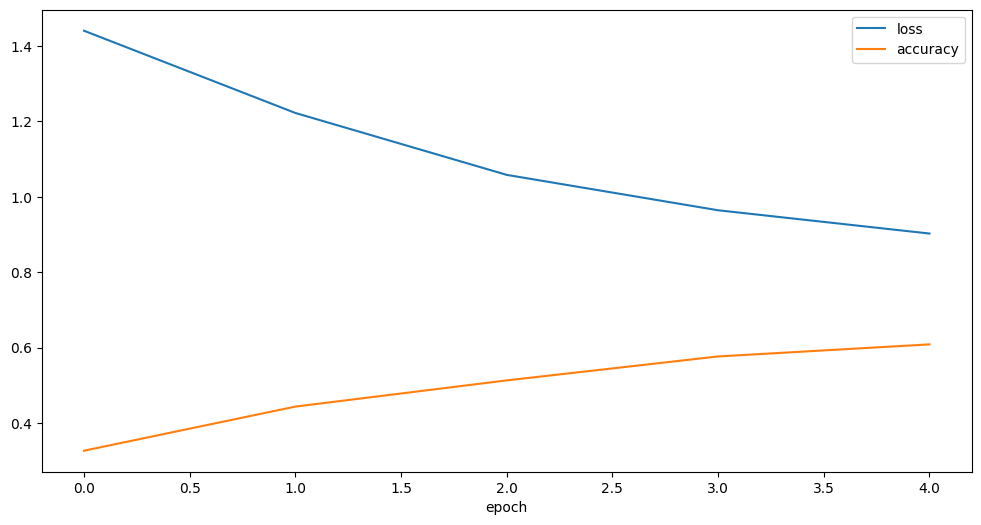

In [ ]:
fig, ax0 = plt.subplots(nrows=1, sharex=True, figsize=(12, 6))  # Unpack axes from the tuple

history_df.plot(x="epoch", y=["loss", "accuracy"], ax=ax0)
# history_df.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1);

In [ ]:
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)
benchmarks

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


63/63 [==============================] - 24s 327ms/step - loss: 0.8582 - accuracy: 0.6260


{'loss': 0.8582404851913452, 'accuracy': 0.6259999871253967}

In [ ]:
import numpy as np

test_text = """Decent poke at an okay price. We got two bowls with sushi rice: salmon and albacore, and salmon and seared cajun tuna.Good: The salmon and tuna were good, and there's a large selection of  mixins and addons -- I consistently get the crab salad, seaweed salad, and tofu skins.
Bad: The albacore was overly salty and many of the pieces were overcooked and rubbery. The sauces are good but I wish there was more added, without having to pay extra."
Overall, nothing spectacular, but Pokeman is an average option in University City"""

test_input = tokernizer(test_text, padding='max_length', truncation=True, max_length=500, return_tensors="tf")

predictions = model.predict(dict(test_input))
print(predictions)
# Get the probabilities for each class
# logits = predictions.logits

# # Apply softmax to get probabilities
# probabilities = tf.nn.softmax(logits, axis=-1).numpy()# Convert logits to probabilities using softmax

# print(probabilities)

1/1 [==============================] - 0s 121ms/step
[[0.06979757 0.4958606  0.37787774 0.04688726 0.0095769 ]]


In [ ]:
predicted_label_index = np.argmax(predictions)
predicted_label_index

1

In [ ]:
print("Ratings :" ,float(predicted_label_index + 1 ))

Ratings : 2.0
